In [1]:
import sys
sys.path.append('../module')

from collections import defaultdict
import math

import numpy as np
import cupy as cp
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from hdc import *

In [2]:
RNG = np.random.default_rng()

In [3]:
if cp.cuda.is_available():
# if cp.cuda.is_available() and False:
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
print(f'xp = {xp.__name__}')

xp = cupy


In [4]:
hdc = Hdc(10000, xp, dtype='f')
hdc.bundle = hdc.bundle_noties
COS_SIM_THRESHOLD = 0.055
HDIST_THRESHOLD = 4700

# hdc = Hdc(1000, xp, dtype='f')
# hdc.bundle = hdc.bundle_noties
# COS_SIM_THRESHOLD = 0.17
# HDIST_THRESHOLD = 410

# hdc = Hdc(2000, xp, dtype='f')
# hdc.bundle = hdc.bundle_noties
# COS_SIM_THRESHOLD = 0.11
# HDIST_THRESHOLD = 880

In [5]:
x1 = hdc()
x2 = hdc()
(x1 == x2).sum(), hdc.hdist(x1, x2), hdc.sim(x1, x2)

(array(5018), array(4982), array(0.0036, dtype=float32))

In [6]:
for _ in range(1000):
    x1 = hdc()
    x2 = hdc()
    s = hdc.sim(x1, x2)
    assert s < COS_SIM_THRESHOLD
    h = hdc.hdist(x1, x2)
    assert h > HDIST_THRESHOLD
    assert np.isclose(hdc.normalize(x1) @ hdc.normalize(x2), s)

In [7]:
xs1 = hdc(10)
xs2 = hdc(10)
xs1_norm = hdc.normalize(xs1)
xs2_norm = hdc.normalize(xs2)

for i, x_pair in enumerate(zip(xs1, xs2)):
    s = hdc.sim(x_pair[0], x_pair[1])
    assert s < COS_SIM_THRESHOLD
    h = hdc.hdist(x_pair[0], x_pair[1])
    assert h > HDIST_THRESHOLD
    assert np.isclose(xs1_norm[i] @ xs2_norm[i], s)    

In [8]:
b = hdc.bundle_noties(x1, x2)
x1[:10], x2[:10], b[:10], hdc.hdist(x1, b), hdc.hdist(x2, b), hdc.sim(x1, b), hdc.sim(x2, b)

(array([-1.,  1., -1., -1.,  1., -1., -1., -1.,  1., -1.], dtype=float32),
 array([ 1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.], dtype=float32),
 array([ 0.,  1.,  0., -1.,  1.,  0.,  0., -1.,  0.,  0.], dtype=float32),
 array(4956),
 array(4956),
 array(0.7102112, dtype=float32),
 array(0.7102112, dtype=float32))

In [9]:
for _ in range(1000):
    b = hdc.bundle_noties(x1, x2)
    assert hdc.sim(x1, b) > COS_SIM_THRESHOLD
    assert hdc.sim(x2, b) > COS_SIM_THRESHOLD

In [10]:
b = hdc.bundle_ties(x1, x2)
x1[:10], x2[:10], b[:10], hdc.hdist(x1, b), hdc.hdist(x2, b),hdc.sim(x1, b), hdc.sim(x2, b)

(array([-1.,  1., -1., -1.,  1., -1., -1., -1.,  1., -1.], dtype=float32),
 array([ 1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.], dtype=float32),
 array([ 1.,  1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.], dtype=float32),
 array(2455),
 array(2501),
 array(0.509, dtype=float32),
 array(0.4998, dtype=float32))

In [11]:
for _ in range(1000):
    b = hdc.bundle_ties(x1, x2)
    assert hdc.sim(x1, b) > COS_SIM_THRESHOLD
    assert hdc.sim(x2, b) > COS_SIM_THRESHOLD
    assert hdc.hdist(x1, b) < HDIST_THRESHOLD
    assert hdc.hdist(x2, b) < HDIST_THRESHOLD

In [12]:
assert hdc.sim(x1, hdc.bundle_noties(x1, x2)) > COS_SIM_THRESHOLD

In [13]:
b = hdc.bind(x1, x2)
x1[:10], x2[:10], b[:10], hdc.hdist(x1, b), hdc.hdist(x2, b), hdc.hdist(x1, x2), hdc.sim(x1, b), hdc.sim(x2, b)

(array([-1.,  1., -1., -1.,  1., -1., -1., -1.,  1., -1.], dtype=float32),
 array([ 1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.], dtype=float32),
 array([-1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1.], dtype=float32),
 array(4877),
 array(4969),
 array(4956),
 array(0.0246, dtype=float32),
 array(0.0062, dtype=float32))

In [14]:
for _ in range(1000):
    b = hdc.bind(x1, x2)
    assert hdc.sim(x1, b) < COS_SIM_THRESHOLD
    assert hdc.sim(x2, b) < COS_SIM_THRESHOLD

In [15]:
s = hdc.shift(x1)
x1[:10], s[:10], hdc.hdist(x1, s), hdc.sim(x1, s)

(array([-1.,  1., -1., -1.,  1., -1., -1., -1.,  1., -1.], dtype=float32),
 array([ 1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1.], dtype=float32),
 array(5022),
 array(-0.0044, dtype=float32))

In [16]:
for _ in range(1000):
    s = hdc.shift(x1)
    assert hdc.sim(x1, s) < COS_SIM_THRESHOLD

In [17]:
m = hdc(3)
m[:,:10], hdc.bundle_noties(m)[:10]

(array([[-1., -1.,  1., -1.,  1., -1.,  1., -1., -1., -1.],
        [-1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.]], dtype=float32),
 array([-1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.], dtype=float32))

In [18]:
for _ in tqdm(range(128*128)):
    xs = hdc(3)
    x1 = xs[0]
    x2 = xs[1]
    x3 = xs[2]
    assert np.array_equal(hdc.bind(x1, hdc.bundle_noties(x2, x3)), hdc.bundle_noties(hdc.bind(x1, x2), hdc.bind(x1, x3)))
    assert np.isclose(hdc.sim(x1, x2), hdc.sim(hdc.bind(x1, x3), hdc.bind(x2, x3)))
    assert np.isclose(hdc.sim(x1, x2), hdc.sim(hdc.shift(x1), hdc.shift(x2)))

  0%|          | 0/16384 [00:00<?, ?it/s]

In [19]:
x1 = hdc()
bundle = hdc.bundle([x1])
assert np.array_equal(x1, bundle)

In [20]:
bipolar_hdv = hdc()
binary_hdv = hdc.to_binary(bipolar_hdv)
assert np.array_equal(hdc.to_bipolar(binary_hdv), bipolar_hdv)

In [21]:
hdvs = hdc(4)
bipolar_bundle = hdc.bundle(hdvs)
print(list(map(lambda hdv: hdc.sim(hdv, bipolar_bundle), hdvs)))
binary_bundle = hdc.to_binary(bipolar_bundle)
assert not np.array_equal(bipolar_bundle, binary_bundle)
assert not np.array_equal(bipolar_bundle, hdc.to_bipolar(binary_bundle))
assert hdc.sim(hdvs[0], hdc.to_bipolar(binary_bundle)) > COS_SIM_THRESHOLD
print(list(map(lambda hdv: hdc.sim(hdv, hdc.to_bipolar(binary_bundle)), hdvs)))

[array(0.4874948, dtype=float32), array(0.4714332, dtype=float32), array(0.46766874, dtype=float32), array(0.4814717, dtype=float32)]
[array(0.379), array(0.3838), array(0.3686), array(0.3892)]


In [22]:
hdvs = hdc(5)
bipolar_bundle = hdc.bundle(hdvs)
binary_bundle = hdc.to_binary(bipolar_bundle)
assert not np.array_equal(bipolar_bundle, binary_bundle)
assert np.array_equal(bipolar_bundle, hdc.to_bipolar(binary_bundle))

In [23]:
hdv1 = hdc.normalize(hdc())
hist = None
trials = 100

for _ in tqdm(range(trials)):
    other_hdvs = hdc.normalize(hdc(10000))
    cos_sims = other_hdvs @ hdv1
    cos_sims *= 100
    h = np.histogram(cos_sims, bins=list(range(-20, 20 + 1, 1)))
    hist = h[0] if hist is None else hist + h[0]

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
df = pd.DataFrame(columns=['Range', 'Count', '%'])
df['Range'] = list(map(lambda pair: f'{pair[0]:6.2f}, {pair[1]:6.2f}', (zip(h[1]/100, h[1][1:]/100))))
df['Count'] = xp_array_from_gpu(hist)
df['%'] = list(map(lambda p: f'{p*100:.4f}%', hist / (np.sum(hist))))
df

,Range,Count,%
0,"-0.20, -0.19",0,0.0000%
1,"-0.19, -0.18",0,0.0000%
2,"-0.18, -0.17",0,0.0000%
3,"-0.17, -0.16",0,0.0000%
4,"-0.16, -0.15",0,0.0000%
5,"-0.15, -0.14",0,0.0000%
6,"-0.14, -0.13",0,0.0000%
7,"-0.13, -0.12",0,0.0000%
8,"-0.12, -0.11",0,0.0000%
9,"-0.11, -0.10",0,0.0000%


In [25]:
hdv1 = hdc()
hist = None
trials = 100
bin_step = hdc.N // 200
bins = list(range(hdc.N // 2 - bin_step * 25, hdc.N // 2 + bin_step * 25, bin_step))

for _ in tqdm(range(trials)):
    other_hdvs = hdc(10000)
    hdists = np.count_nonzero(hdv1 != other_hdvs, axis=1)
    h = np.histogram(hdists, bins=bins)
    hist = h[0] if hist is None else hist + h[0]

  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
df = pd.DataFrame(columns=['Range', 'Count', '%'])
df['Range'] = list(map(lambda pair: f'{pair[0]} - {pair[1]}', (zip(h[1], h[1][1:]))))
df['Count'] = xp_array_from_gpu(hist)
df['%'] = list(map(lambda p: f'{p*100:.4f}%', hist / (np.sum(hist))))
df

,Range,Count,%
0,3750 - 3800,0,0.0000%
1,3800 - 3850,0,0.0000%
2,3850 - 3900,0,0.0000%
3,3900 - 3950,0,0.0000%
4,3950 - 4000,0,0.0000%
5,4000 - 4050,0,0.0000%
6,4050 - 4100,0,0.0000%
7,4100 - 4150,0,0.0000%
8,4150 - 4200,0,0.0000%
9,4200 - 4250,0,0.0000%


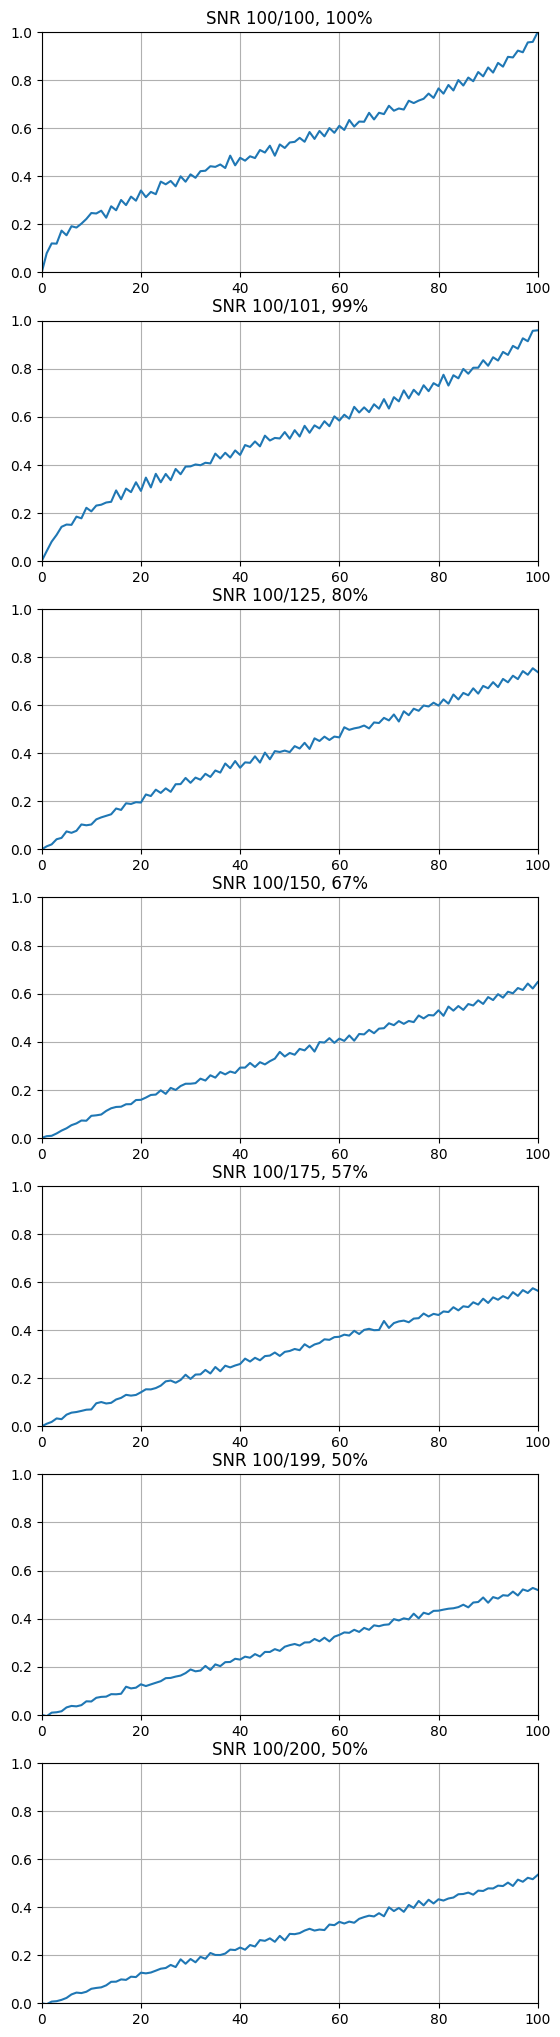

In [27]:
signal_hdvs = hdc(100)
signal_points = list(range(0, signal_hdvs.shape[0] + 1))
bundle = hdc.bundle(signal_hdvs)

noise_hdvs = hdc(100)
noise_points = [0, 1, 25, 50, 75, 99, 100]

values = []

for noise_hdv_count in noise_points:
    noise_hdv_indices = RNG.choice(noise_hdvs.shape[0], noise_hdv_count, replace=False)
    noise_level_values = []
    
    for signal_hdv_count in signal_points:
        if signal_hdv_count == 0:
            noise_level_values.append(0)
            continue
            
        signal_hdv_indices = RNG.choice(signal_hdvs.shape[0], signal_hdv_count, replace=False)
        b = hdc.bundle(list(noise_hdvs[noise_hdv_indices]) + list(signal_hdvs[signal_hdv_indices]))
        sim = hdc.sim(bundle, b)
        noise_level_values.append(xp_array_from_gpu(sim))

    values.append(noise_level_values)

fig, ax = plt.subplots(len(noise_points)) 
fig.set_figheight(fig.get_figwidth() * 4)

for x in range(len(noise_points)):
    ax[x].set_ylim(0, 1)
    ax[x].set_xlim(0, max(signal_points))
    ax[x].grid()
    ax[x].plot(signal_points, values[x])
    ax[x].set_title(f'SNR {len(signal_hdvs)}/{len(signal_hdvs)+noise_points[x]}, {len(signal_hdvs)/(len(signal_hdvs)+noise_points[x])*100:.0f}%')
    
plt.show()

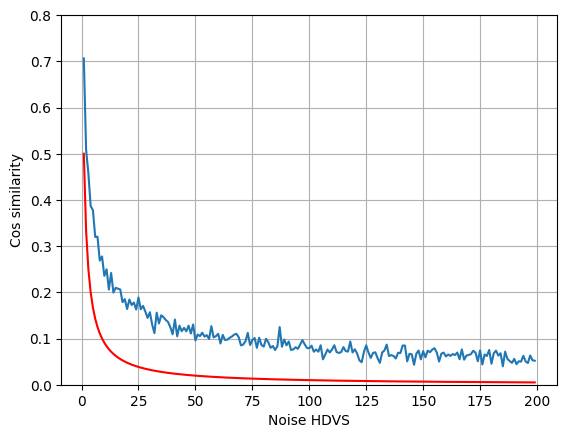

In [28]:
signal_hdv = hdc()
points = list(range(1, 200))
values = []
theoretical_snr = []

for x in points:
    noise_hdvs = hdc(x + 1)[:x]
    b = hdc.bundle([signal_hdv] + list(noise_hdvs))
    sim = hdc.sim(signal_hdv, b)
    values.append(xp_array_from_gpu(sim))
    theoretical_snr.append(1/(1+x))

#plt.bar(points, values)
plt.plot(points, values)
plt.xlabel('Noise HDVS')
plt.ylabel('Cos similarity')
#ax2 = plt.gca().twinx()
#ax2.plot(points, theoretical_snr, '-r')
plt.plot(points, theoretical_snr, '-r')
plt.ylim(0, 0.8)
plt.grid()
plt.show()

In [29]:
x1 = hdc()
x2 = hdc()
bundle = hdc.bundle(x1, x2)
z = hdc.debundle(bundle, x2)
hdc.sim(z, x1), hdc.sim(z, x2)

(array(0.7115476, dtype=float32), array(-0.7115476, dtype=float32))

In [30]:
x1 = hdc()
x2 = hdc()
x3 = hdc()

bundle1 = hdc.bundle(x1, x2, x3)
bundle2 = hdc.bundle(hdc.bundle(x1, x2), x3)
assert not np.array_equal(bundle1, bundle2)
hdc.sim(x1, bundle1), hdc.sim(x2, bundle1), hdc.sim(x3, bundle1), hdc.sim(x1, bundle2), hdc.sim(x2, bundle2), hdc.sim(x3, bundle2)

(array(0.494, dtype=float32),
 array(0.4862, dtype=float32),
 array(0.5114, dtype=float32),
 array(0.28723928, dtype=float32),
 array(0.27826664, dtype=float32),
 array(0.8693101, dtype=float32))

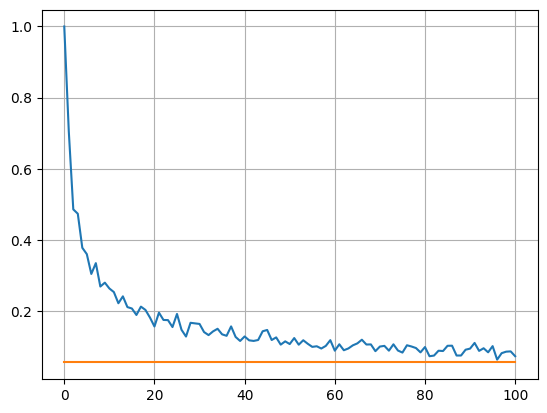

In [31]:
source = hdc()
target = hdc()
map_hdc = hdc.bind(source, target)
source_mapped = hdc.bind(source, map_hdc)
assert np.isclose(hdc.sim(source_mapped, target), 1)

noise_levels = range(0, 100 + 1)
sim_values = []

for noise_level in noise_levels:
    noise = hdc(noise_level)
    source_noise = hdc.bundle(xp.vstack([source, noise]))
    source_noise_mapped = hdc.bind(source_noise, map_hdc)
    sim = xp_array_from_gpu(hdc.sim(source_noise_mapped, target))
    sim_values.append(sim)

plt.plot(noise_levels, sim_values)
plt.plot([0, 100], [COS_SIM_THRESHOLD, COS_SIM_THRESHOLD])
plt.grid()
plt.show()

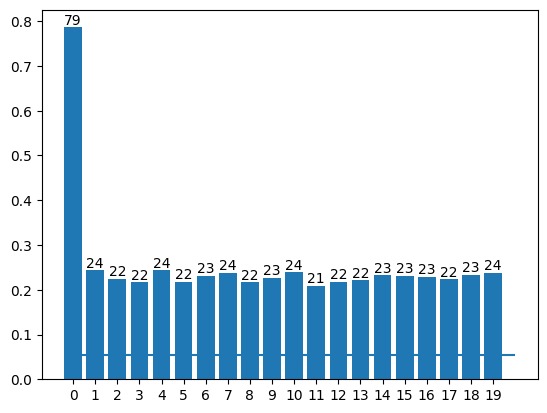

In [32]:
source = hdc()
source_population = None

for i in range(20):
    noise = hdc(3)
    source_noise =  hdc.bundle(xp.vstack([source, noise]))
    arrays_to_stack = [source_population] if not source_population is None else []
    arrays_to_stack.append(source_noise)
    source_population = xp.vstack(arrays_to_stack)

target = hdc()
map_hdc = hdc.bind(target, source_population[0])
sims = []

for i in range(source_population.shape[0]):
    sim = xp_array_from_gpu(hdc.sim(target, hdc.bind(source_population[i], map_hdc)))
    sims.append(sim)

b = plt.bar(list(map(str, range(source_population.shape[0]))), sims)
plt.bar_label(b, list(map(lambda s: f'{s*100:.0f}', sims)))
plt.hlines(COS_SIM_THRESHOLD, 0, source_population.shape[0])
plt.show()

In [33]:
x_source = hdc()
x_source_population = None

for i in range(10):
    noise = hdc(50)
    x_source_noise =  hdc.bundle(xp.vstack([x_source, noise]))
    arrays_to_stack = [x_source_population] if not x_source_population is None else []
    arrays_to_stack.append(x_source_noise)
    x_source_population = xp.vstack(arrays_to_stack)

x_target = hdc()
mappings = None
df_stats = pd.DataFrame(columns=['att_no'] + list(map(lambda q: f'm_{q:02}', range(x_source_population.shape[0]))))

for att_no in range(10):
    m_vals = [0] * x_source_population.shape[0]
    
    for i in range(x_source_population.shape[0]):
        x = x_source_population[i]
        new_mapping = hdc.bind(x, x_target)
        
        if mappings is None:
            mappings = xp.vstack([new_mapping])
        else:
            nothing_found = True
            
            for m_i, mapping in enumerate(mappings):
                y = hdc.bind(x, mapping)
                sim = hdc.sim(y, x_target)
    
                if sim >= COS_SIM_THRESHOLD:
                    mapping[:] = hdc.bundle(mapping, new_mapping)
                    nothing_found = False
                    m_vals[m_i] += 1
                    
            if nothing_found:
                mappings = xp.vstack([mappings, new_mapping])

    df_stats.loc[len(df_stats)] = [att_no] + m_vals

df_stats

,att_no,m_00,m_01,m_02,m_03,m_04,m_05,m_06,m_07,m_08,m_09
0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,1
2,2,1,1,1,1,1,1,1,1,1,1
3,3,1,1,1,1,1,1,1,1,1,1
4,4,1,1,1,1,1,1,1,1,1,1
5,5,1,1,1,1,1,1,1,1,1,1
6,6,1,1,1,1,1,1,1,1,1,1
7,7,1,1,1,1,1,1,1,1,1,1
8,8,1,1,1,1,1,1,1,1,1,1
9,9,1,1,1,1,1,1,1,1,1,1


In [34]:
#mappings[0] = hdc.bundle(mappings[0], mappings[1], mappings[2])
mappings[0] = hdc.bundle(mappings)

df_stats = pd.DataFrame(columns=list(map(lambda q: f'm_{q:02}', range(x_source_population.shape[0]))))

for i in range(x_source_population.shape[0]):
    df_stats.loc[f'sample_{i}'] = [0.0] * x_source_population.shape[0]

for i in range(x_source_population.shape[0]):
    x = x_source_population[i]
        
    for m_i, mapping in enumerate(mappings):
        y = hdc.bind(x, mapping)
        sim = hdc.sim(y, x_target)

        # if sim >= COS_SIM_THRESHOLD:
        df_stats.loc[f'sample_{i}', f'm_{m_i:02}'] = sim

df_stats

,m_00,m_01,m_02,m_03,m_04,m_05,m_06,m_07,m_08,m_09
sample_0,0.290528,0.0252,0.0172,0.0026,0.0142,0.0158,0.0054,0.0140,0.0030,0.0068
sample_1,0.290300,1.0000,0.0204,0.0106,-0.0014,0.0266,0.0062,-0.0104,0.0010,-0.0024
sample_2,0.304633,0.0204,1.0000,0.0166,0.0194,0.0330,0.0110,0.0064,0.0010,-0.0024
sample_3,0.302358,0.0106,0.0166,1.0000,0.0208,0.0200,0.0052,0.0238,0.0176,0.0170
sample_4,0.298945,-0.0014,0.0194,0.0208,1.0000,0.0180,0.0100,0.0142,0.0128,0.0142
sample_5,0.318966,0.0266,0.0330,0.0200,0.0180,1.0000,0.0276,0.0134,0.0072,0.0142
sample_6,0.298945,0.0062,0.0110,0.0052,0.0100,0.0276,1.0000,0.0282,0.0104,0.0070
sample_7,0.301675,-0.0104,0.0064,0.0238,0.0142,0.0134,0.0282,1.0000,0.0158,0.0140
sample_8,0.284612,0.0010,0.0010,0.0176,0.0128,0.0072,0.0104,0.0158,1.0000,0.0202
sample_9,0.289618,-0.0024,-0.0024,0.0170,0.0142,0.0142,0.0070,0.0140,0.0202,1.0000


In [35]:
mappings_norm = hdc.normalize(mappings)
mappings_norm_cross = xp_array_from_gpu(mappings_norm @ mappings_norm.T)
mappings_norm_cross[mappings_norm_cross < COS_SIM_THRESHOLD] = 0
pd.DataFrame(mappings_norm_cross)

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.290300,0.304633,0.302358,0.298945,0.318966,0.298945,0.301675,0.284612,0.289618
1,0.290300,1.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.304633,0.000000,1.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.302358,0.000000,0.000000,1.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.298945,0.000000,0.000000,0.000000,1.000001,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.318966,0.000000,0.000000,0.000000,0.000000,1.000001,0.000000,0.000000,0.000000,0.000000
6,0.298945,0.000000,0.000000,0.000000,0.000000,0.000000,1.000001,0.000000,0.000000,0.000000
7,0.301675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000001,0.000000,0.000000
8,0.284612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000001,0.000000
9,0.289618,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000001


In [36]:
x1 = hdc()
z1 = hdc.zero()
zs = hdc.zero(10)
assert np.isnan(hdc.sim(x1, z1))

for z in zs:
    assert np.isnan(hdc.sim(x1, z))
    assert np.isnan(hdc.sim(z1, z))

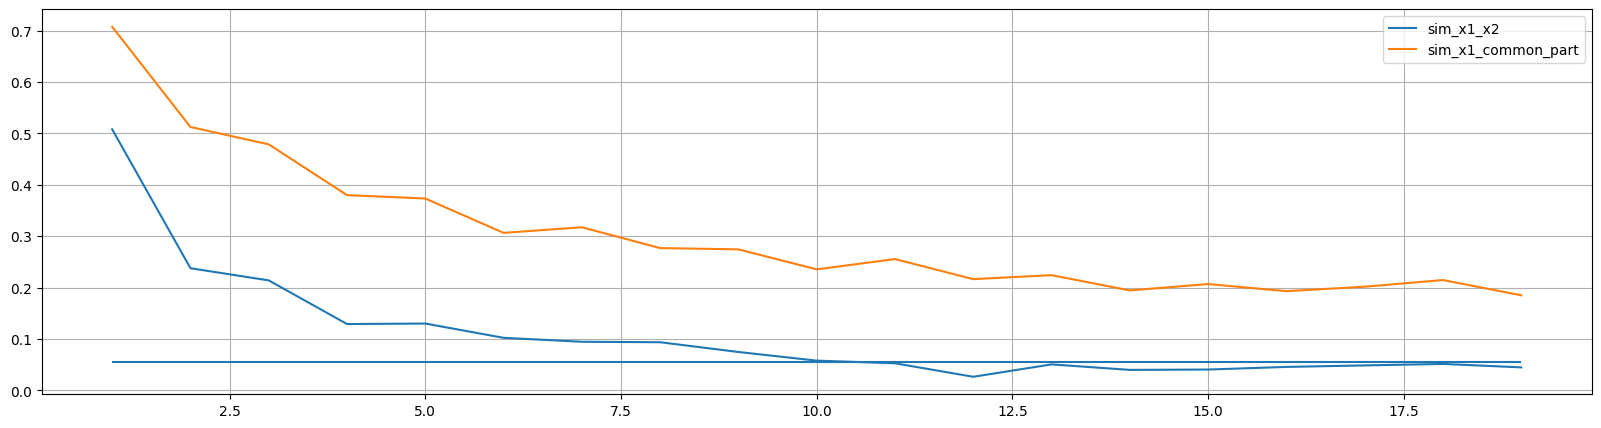

,noise_comps,sim_x1_x2,sim_x1_common_part,hdist_x1_x2,hdist_x1_common_part,hdist_x1_x2_is_close,hdist_x1_common_part_is_close
0,1,0.507928,0.707390,4935.0,4996.0,False,False
1,2,0.237600,0.512400,3812.0,2438.0,True,True
2,3,0.213932,0.478600,6013.0,4935.0,False,False
3,4,0.129000,0.379800,4355.0,3101.0,True,True
4,5,0.129972,0.373269,6214.0,5053.0,False,False
5,6,0.102200,0.306400,4489.0,3468.0,True,True
6,7,0.094530,0.317338,6240.0,5040.0,False,False
7,8,0.093600,0.276800,4532.0,3616.0,True,True
8,9,0.074644,0.274299,6283.0,4987.0,False,False
9,10,0.057800,0.235400,4711.0,3823.0,False,True


In [37]:
common_part = hdc(1)
df = pd.DataFrame(columns=['noise_comps', 'sim_x1_x2', 'sim_x1_common_part', 'hdist_x1_x2', 'hdist_x1_common_part'])

for i in range(1, common_part.shape[0] * 10 + 10):
    x1_raw = hdc(i)
    x1_raw = np.vstack([x1_raw, common_part])
    x1 = hdc.bundle(x1_raw)
    # x1 = hdc.bundle_ties(x1_raw) # good for hdist

    x2_raw = hdc(i)
    x2_raw = np.vstack([x2_raw, common_part])
    x2 = hdc.bundle(x2_raw)
    # x2 = hdc.bundle_ties(x2_raw) # good for hdist

    df.loc[len(df)] = [i, float(hdc.sim(x1, x2)), float(hdc.sim(x1, hdc.bundle(common_part))), float(hdc.hdist(x1, x2)), float(hdc.hdist(x1,  hdc.bundle(common_part)))]

df.noise_comps = df.noise_comps.astype(int)
df['hdist_x1_x2_is_close'] = df.hdist_x1_x2 < 4700
df['hdist_x1_common_part_is_close'] = df.hdist_x1_common_part < 4700
plt.figure(figsize=(20,5))
plt.plot(df.noise_comps, df['sim_x1_x2'], label='sim_x1_x2')
plt.plot(df.noise_comps, df['sim_x1_common_part'], label='sim_x1_common_part')
plt.hlines(COS_SIM_THRESHOLD, df.noise_comps.min(), df.noise_comps.max())
plt.grid()
plt.legend()
plt.show()

df

In [38]:
common_part = hdc(1)
assert np.array_equal(hdc.bundle(common_part), common_part[0])

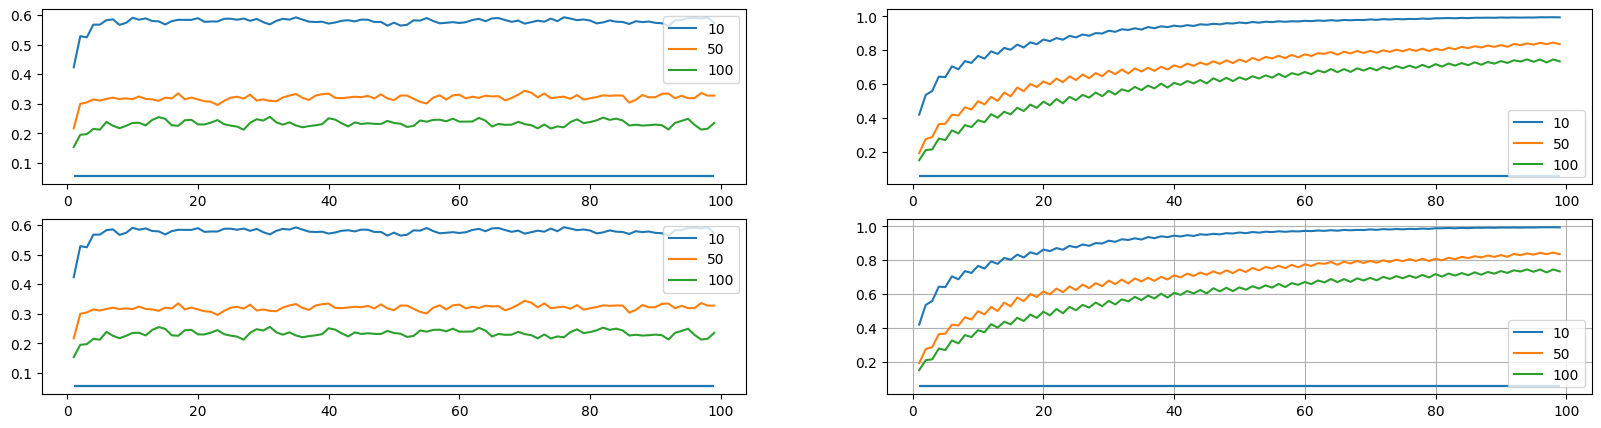

In [39]:
pure_signal = hdc(5)
dfs_capped = defaultdict(lambda: pd.DataFrame(columns=['distil_cycle', 'sim']))
dfs_uncapped = defaultdict(lambda: pd.DataFrame(columns=['distil_cycle', 'sim']))
distil_cycles = 100

# capped version
for noise_comps in [10, 50, 100]:
    distil_bundle = None

    for i in range(1, distil_cycles):
        x1_raw = hdc(noise_comps)
        x1_raw = np.vstack([x1_raw, pure_signal])
        x1 = hdc.bundle(x1_raw)
    
        distil_bundle = x1 if distil_bundle is None else hdc.bundle(distil_bundle, x1)

        df = dfs_capped[noise_comps]
        df.loc[len(df)] = [i, float(hdc.sim(distil_bundle, hdc.bundle(pure_signal)))]

# uncapped version
for noise_comps in [10, 50, 100]:
    x1s = []
    
    for i in range(1, distil_cycles):
        x1_raw = hdc(noise_comps)
        x1_raw = np.vstack([x1_raw, pure_signal])
        x1 = hdc.bundle(x1_raw)
        x1s.append(x1)

        distil_bundle = hdc.bundle(x1s)
        
        df = dfs_uncapped[noise_comps]
        df.loc[len(df)] = [i, float(hdc.sim(distil_bundle, hdc.bundle(pure_signal)))]

plt.figure(figsize=(20,5))

for i, dfs in enumerate([dfs_capped, dfs_uncapped]):
    plt.subplot(2, 2, i + 1)
    
    for noise_comps, df in dfs.items():
        df.distil_cycle = df.distil_cycle.astype(int)
        plt.plot(df.distil_cycle, df['sim'], label=f'{noise_comps}')
        plt.hlines(COS_SIM_THRESHOLD, df.distil_cycle.min(), df.distil_cycle.max())
        plt.legend(loc='best')

    plt.subplot(2, 2, i + 3)
    
    for noise_comps, df in dfs.items():
        df.distil_cycle = df.distil_cycle.astype(int)
        plt.plot(df.distil_cycle, df['sim'], label=f'{noise_comps}')
        plt.hlines(COS_SIM_THRESHOLD, df.distil_cycle.min(), df.distil_cycle.max())
        plt.legend(loc='best')

plt.grid()
plt.show()


In [40]:
pure_signal = hdc(5)
pure_signal_bundle = hdc.bundle(pure_signal)
distil_cycles = 100
hdvs = []
hdvs_01 = []

# HDC BUNDLING
for i in range(distil_cycles):
    noise_hdvs = hdc(50)
    hdv = np.vstack([noise_hdvs, pure_signal])
    hdv = hdc.bundle(hdv)
    hdvs.append(hdv)
    hdv_01 = hdv.copy()
    hdv_01[hdv_01 == -1] = 0
    hdvs_01.append(hdv_01)
    
distil_bundle = hdc.bundle(hdvs)

# HEBB PRINCIPAL COMPONENTS (PC)
# for prune_factor in [56]:
# for nu in tqdm(range(1, 100)):
pc_mask = xp.ones(hdc.N)
pc_counters = xp.ones(hdc.N)
nu = 0.01
# nu = nu / 100

for epoch in range(100):
    for hdv_01 in hdvs_01:
        x = hdv_01 * pc_mask
        y = hdv_01 @ pc_counters
    
        nomin = pc_counters + x * (nu * y)
        denom = nomin.max()
        pc_counters = (nomin / denom)

        # nomin = pc_counters + x * (nu * y)
        # denom = np.linalg.norm(pc_counters + x * (nu * y))
        # pc_counters = nomin / denom
    
    # Pruning
    pc_mask = (pc_counters >= np.max(pc_counters) * 56 / 100)
    pc_counters = pc_counters * pc_mask
    
    nu *= 0.9

pc_mask = pc_mask.astype('b')
hdc.sim(distil_bundle, pure_signal_bundle), hdc.sim(pc_mask, pure_signal_bundle), hdc.sim(distil_bundle, pc_mask)

(array(0.8438995, dtype=float32), array(0.43828253), array(0.48923565))

In [41]:
signal = hdc()
columns = defaultdict(list)
tie_breaker = hdc()

for i in tqdm(range(1, 400 + 1), leave=False):
    noise = hdc(i)
    bundle = hdc.bundle_noties(np.vstack([signal, noise]))
    columns['noise_comps'].append(i)
    columns['signal_to_bundle_sim'].append(hdc.sim(signal, bundle)) # cosine similarity
    bundle = xp.where(bundle == 0, tie_breaker, bundle)
    columns['signal_to_bundle_hd'].append(hdc.hdist(signal, bundle)) # hamming distance

df = pd.DataFrame(columns)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

ax1.set_title('Cosine similarity')
ax1.plot(df.noise_comps, df.signal_to_bundle_sim)
ax1.hlines(COS_SIM_THRESHOLD, 0, df.noise_comps.max(), color='r')

ax2.set_title('Hamming distance')
ax2.plot(df.noise_comps, df.signal_to_bundle_hd)
ax2.set_ylim(xp.min(df.signal_to_bundle_hd), hdc.N // 2)
ax2.hlines(HDIST_THRESHOLD, 0, df.noise_comps.max(), color='r')
ax2.annotate(str(HDIST_THRESHOLD), xy=(0, HDIST_THRESHOLD));

  0%|          | 0/400 [00:00<?, ?it/s]

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

ax1.set_title('Cosine similarity')
ax1.plot(df.noise_comps, df.signal_to_bundle_sim)
ax1.hlines(COS_SIM_THRESHOLD, 0, df.noise_comps.max(), color='r')

ax2.set_title('Hamming distance')
ax2.plot(df.noise_comps, df.signal_to_bundle_hd)
ax2.set_ylim(xp.min(df.signal_to_bundle_hd), hdc.N // 2)
# ax2.hlines(HDIST_THRESHOLD, 0, df.noise_comps.max(), color='r')
# ax2.annotate(str(HDIST_THRESHOLD), xy=(0, HDIST_THRESHOLD));

ax2.hlines(5000 - 50 * 4, 0, df.noise_comps.max(), color='r')
ax2.annotate(str(5000 - 50 * 4), xy=(0, 5000 - 50 * 4));

In [ ]:
columns = defaultdict(list)
thres_list = (0.05 + np.arange(12) * 0.01)

for N in tqdm(range(1000, 10000 + 1000, 1000)):
# for N in tqdm(range(1000, 2000, 1000)):
    hdc_n = Hdc(N, xp, dtype='f')
    columns['N'].append(N)

    signal = hdc_n()
    signal_norm = hdc_n.normalize(signal)
    others = hdc_n.normalize(hdc_n(100_000))
    cos_sims = others @ signal_norm

    for thres in thres_list:
        matches_count = (cos_sims > thres).sum()
        # probability (in %) to meet similar signal at random for given thres
        prob = 100 * (matches_count / others.shape[0])

        # Number of signals a hdv bundle can carry at given thres
        capacities = []
        
        for _ in range(10):
            for i in range(1, 200 + 1):
                capacity = i
                others2 = hdc_n(i)
                bundle = hdc_n.bundle_noties(np.vstack([signal, others2]))
                
                if hdc_n.sim(signal, bundle) < thres:
                    break
            
            capacities.append(capacity)

        columns[f'{thres:.2f}'].append(f'{prob:.4f}% / {np.array(capacities).mean().astype(int)}')

In [ ]:
pd.DataFrame(columns)

In [ ]:
# sbv_dims = [1000]
# non_zero_bits_list = range(1, 10)
# sbv_dims = [1000, 1200, 1500, 1800, 2000, 2500, 3000, 3500, 4000, 5000]
# sbv_dims = [256, 512]
# sbv_dims = [256, 512, 1024]
# sbv_dims = [1200, 1300, 1400, 1500]
sbv_dims = [1000]
# non_zero_bits_list = range(2, 26)
non_zero_bits_list = range(2, 31)
index = []
columns = defaultdict(list)
# min_entities_count = 128 ** 2 # ~16k 
# min_entities_count = 32 ** 2 # ~1k
# min_entities_count = 100
# min_entities_count = 9 * 4 * 50 * 2 # 10 degree, 3600
# min_entities_count = 6 * 4 * 50 * 2 # 15 degree, 2400
# min_entities_count = 5 * 4 * 50 * 2 # 18 degree, 2000
# min_entities_count = 3 * 4 * 50 * 2 # 30 degree, 1200
# min_entities_count = 36 * 128 * 128
# min_entities_count = 128 * 10 + 128 * 10 + 36 * 10
# min_entities_count = 1000 * 24 # 15 degree fidelity
min_entities_count = 1000

for sbv_dim in tqdm(sbv_dims, desc='sbv_dim'):
    index.append((min_entities_count, sbv_dim, 'bundle_size_0_FP'))
    index.append((min_entities_count, sbv_dim, 'bundle_size_1_FP'))
    index.append((min_entities_count, sbv_dim, 'bundle_size_2_FP'))
    index.append((min_entities_count, sbv_dim, 'bundle_ones_count_0_FP'))
    index.append((min_entities_count, sbv_dim, 'bundle_ones_count_1_FP'))
    index.append((min_entities_count, sbv_dim, 'bundle_ones_count_2_FP'))

    for non_zero_bits in tqdm(non_zero_bits_list, leave=False, desc='non_zero_bits'):
        bundle_size_0_FP = 0
        bundle_size_1_FP = 0
        bundle_size_2_FP = 0
        bundle_size_to_max_ones_count = {}
        entities_count = math.comb(sbv_dim, non_zero_bits)

        if entities_count >= min_entities_count:
            entities = np.zeros((min_entities_count, sbv_dim), dtype='f')
            unique_entity_codes = set()
            
            for i in tqdm(range(entities.shape[0]), leave=False, desc='entities'):
                attempts_to_get_unique_entity_code = 10

                for _ in range(attempts_to_get_unique_entity_code):
                    ii = RNG.choice(sbv_dim, non_zero_bits, replace=False)
                    entity_code = tuple(sorted(ii))

                    if not entity_code in unique_entity_codes:
                        entities[i][ii] = 1
                        unique_entity_codes.add(entity_code)
                        break
                else:
                    assert False, f'Failed to get unique entity code within {attempts_to_get_unique_entity_code} attempts'

            assert np.all(entities.sum(axis=1) == non_zero_bits)
            entities = xp_array_to_gpu(entities)

            for bundle_size in tqdm(list(range(1, 101)), leave=False, desc='bundle_size'):
                errors_count_list = []
                max_ones_count = 0
                
                for _ in range(50):
                    # entity_inds = RNG.choice(entities.shape[0], bundle_size, replace=False)
                    # entities_for_bundle = entities[entity_inds]
                    # sbv = xp.where(entities_for_bundle.sum(axis=0) > 0, 1, 0)
                    # entities_for_bundle_restored = entities[((entities @ sbv) == non_zero_bits)]
                    # errors_count = xp.count_nonzero(entities_for_bundle.sum(axis=0) != entities_for_bundle_restored.sum(axis=0))

                    entity_inds = RNG.choice(entities.shape[0], bundle_size, replace=False)
                    entity_inds_mask = xp.zeros(entities.shape[0], dtype=bool)
                    entity_inds_mask[entity_inds] = True
                    entities_for_bundle = entities[entity_inds]
                    sbv = xp.where(entities_for_bundle.sum(axis=0) > 0, 1, 0)
                    entity_inds_mask_restored = (entities @ sbv) == non_zero_bits
                    assert xp.all((entity_inds_mask_restored * entity_inds_mask) == entity_inds_mask) # assert than we don't lose any entities during restore procedure
                    errors_count = int((entity_inds_mask != entity_inds_mask_restored).sum()) # count False positives (phantom entities)
                    errors_count_list.append(errors_count)
                    max_ones_count = max(max_ones_count, sbv.sum())

                bundle_size_to_max_ones_count[bundle_size] = max_ones_count
                errors_count_list = np.array(errors_count_list)
                min_errors_count = np.min(errors_count_list)
                        
                if min_errors_count > 2:
                    break

                bundle_size_0_FP = bundle_size if np.all(errors_count_list <= 0) and bundle_size_0_FP == bundle_size - 1 else bundle_size_0_FP
                bundle_size_1_FP = bundle_size if np.all(errors_count_list <= 1) and bundle_size_1_FP == bundle_size - 1 else bundle_size_1_FP
                bundle_size_2_FP = bundle_size if np.all(errors_count_list <= 2) and bundle_size_2_FP == bundle_size - 1 else bundle_size_2_FP

        columns[non_zero_bits].append(bundle_size_0_FP)        
        columns[non_zero_bits].append(bundle_size_1_FP)        
        columns[non_zero_bits].append(bundle_size_2_FP)        
        columns[non_zero_bits].append(bundle_size_to_max_ones_count[bundle_size_0_FP])
        columns[non_zero_bits].append(bundle_size_to_max_ones_count[bundle_size_1_FP])
        columns[non_zero_bits].append(bundle_size_to_max_ones_count[bundle_size_2_FP])
        
        # columns[non_zero_bits].append(bundle_size_0_FP * non_zero_bits)
        # columns[non_zero_bits].append(bundle_size_1_FP * non_zero_bits)
        # columns[non_zero_bits].append(bundle_size_2_FP * non_zero_bits)

In [ ]:
pd.DataFrame(columns, index=pd.MultiIndex.from_tuples(index, names=['entities', 'N', 'param']))[range(11,31)]